# COGS 108 - Final Project

# Names and PID
- Anthony Ostia &emsp; A13903305
- Ramin Atrian &emsp; A15691021
- Chuyang Xiao &emsp; A13722916
- Yifeng Zhang &emsp; A13820262
- Ian Nelson &emsp; A15738482

# Introduction
In this final project of Intro to Data science, we are trying to generate a movie recommendation system for IMDB users with respect to their historical ratings. At first, after obtaining the datasets about both films' final ratings and individual users' ratings, we would try to combine them together with movieID as the key for further comparisons. Next, by visualizing the collected data, we would study the correlation between individual as well as final ratings of films and film genres. At last, we would use the model we generate to recommend films for each individual user. 

# Background 
Since the beginning of the 20th century, film has been an important recreation to human beings possessing both artistic and commercial significance. Moreover, in the Information Age, rather than being overwhelmed by the gigantic informative flow, film won unprecedented attention from the population with the aid of widespread accessibility to the Internet. Just like Hsu (2014) argued in his essay, in the era of Web 2.0, film critics are no longer privileges limited to professionals yet typical rights to common audiences as well, due to the introduction of film rating websites such as IMDB or Rotten Tomatoes: each audience could comment or grade films online and then share their evaluations and opinions to the public. Consequently, the data collected thereby is not only abundant in quantity, but also diverse in nature, including millions of users’ personal information as well as preference of films. Hence, considering it a perfect dataset to study users’ attributes to films, we would like to focus on the ratings on movie websites in this project.

As increasing audiences begin to consider online ratings as critical criteria to decide whether or  not to see a film, a number of data scientists struggle to explore the rating data, which has provided us with the direction of further research. In the research accomplished by Hsu (2014) focusing on predicting the movies user rating based on the IMDB attributes, by analyzing the ratings and critics of 31506 movies, they generated a mathematical model mimicking the manners of the preference of general IMDB users, and hence predicted the final rating of a newly coming movie via entering related parameters to it. Regardingly, we found that instead of being purely independent, the IMDB ratings of new films could be roughly predicted by past data. Furthermore, in Breuss’s research (2012), the personal information on users’ social media, including gender, hobby, or regular activities, was taken into account and therefore, predicted the IMDB movie ratings they might give, which inspires that individuals’ statistics could also be of concern. 

All in all, in this data science project, we will combine these two studies and step forward: we will study what kind of movies will a user like based on the historical ratings and review texts of that user on movies he/she has seen previously. From our perspective, this study is not only interesting but also quite applicable, could possibly promote the recommendation system in movie rating websites.

Reference:
1. Hsu, P. Y., Shen, Y. H., & Xie, X. A. (2014, October). Predicting movies user ratings with imdb attributes. In International Conference on Rough Sets and Knowledge Technology (pp. 444-453). Springer, Cham.
2. Oghina, A., Breuss, M., Tsagkias, M., & De Rijke, M. (2012, April). Predicting imdb movie ratings using social media. In European Conference on Information Retrieval (pp. 503-507). Springer, Berlin, Heidelberg.

# Research Question
How to recommend movies in their favorite genres to each individual IMDB user according to their historical ratings?

# Hypothesis
Within this data science group project, we would like to develope a recommendation system for the movie rating websites which involves predicting the users' preference in movie according to their rating history and then, provide them with certain genre of movies that they favor. Hence, we generated a couple of hypotheses with respect to this topic:
1. With respect to the users, one would like to rate higher on the genres (higher than the average) he or she loves, which indicates his or her passion. On the opposite, for the genres he or she dislikes, his or hers ratings would be much lower(lower than or equal to the average).
2. Moreover, if a user loves a certain genre of film, he or she tends to watch this genre of movies more.
3. If a user loves a certain genre of move, this genre of movie must exist among the movies he or she rates the highest.

# Datasets

Data on ratings comes from
https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7#

This dataset contains over 200000000 ratings from 138493 users, containing the movieID they rates, the scores they give to each film, and the timestamps of the ratings.

Data about movies comes from
https://www.kaggle.com/grouplens/movielens-20m-dataset#tag.csv

This data contains the information of 27277 movies, including their movieID, title and genres.

# Setup

In [1]:
#import the useful modules and packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# load in our datasets in csv with pandas method.
df_rating = pd.read_csv('rating.csv') 
df_movie = pd.read_csv('movie.csv',dtype = {'title':str, 'genres':str, 'movieId':int})

In [3]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Data Cleaning / Pre-processing

In [5]:
df_rating = df_rating.drop(columns = ['timestamp'])

In [6]:
# drop data with missing values
df_rating.dropna(inplace=True)
df_movie.dropna(inplace=True)

In [7]:
# convert the original rating in the scale of 5 into the rating in the scale of 10.
df_rating['rating'] *= 2

In [8]:
# The original ratings dataset is too large
# we would select the first 2000 users as our training set
train = df_rating[df_rating['userId']<=2000]

In [9]:
rows_to_drop = []
for n in range(len(train)):
    if train['movieId'][n] not in df_movie['movieId']:
        rows_to_drop.append(n)

In [10]:
# remove rows without ratings
train = train.drop(rows_to_drop)
frames = [train[train['userId'] == i+1][-5:] for i in range(2000)]
test = pd.concat(frames)
todrop = test.index.values
train = train.drop(todrop)

In [11]:
# calculate the average ratings
average_ratings = {}
for index, row in train.iterrows():
    if row[1] in average_ratings:
        average_ratings[row[1]].append(row[2])
    else:
        average_ratings[row[1]] = [row[2]]
        
average_dict = {}
for key,value in average_ratings.items():
    average_dict[key] = sum(value)/len(value)
    
train['average_score'] = [average_dict[row[1]] for index,row in train.iterrows()]

In [12]:
# append genres to train dataset
genre = []
for i in train['movieId']:
    g = ""
    for val in df_movie[df_movie['movieId'] == i]['genres']:
        g = val
    genre.append(g)
train['genres'] = genre

In [13]:
# calculate variance for each user on each movie
train['variance'] = train.apply(lambda row: row.rating - row.average_score, axis=1)

In [14]:
# calculate average score for the test set
average_ratings = {}
for index, row in test.iterrows():
    if row[1] in average_ratings:
        average_ratings[row[1]].append(row[2])
    else:
        average_ratings[row[1]] = [row[2]]

average_dict = {}
for key,value in average_ratings.items():
    average_dict[key] = sum(value)/len(value)

test['average_score'] = [average_dict[row[1]] for index,row in test.iterrows()]

In [15]:
# append genres to the test set
genre = []
for i in test['movieId']:
    g = ""
    for val in df_movie[df_movie['movieId'] == i]['genres']:
        g = val
    genre.append(g)
test['genres'] = genre

In [105]:
test['variance'] = test.apply(lambda row: row.rating - row.average_score, axis=1)
test['recommend'] = test.apply(lambda row: row.rating >= 6.0, axis=1)

In [106]:
train.head()

,userId,movieId,rating,average_score,genres,variance
0,1,2,7.0,6.484076,Adventure|Children|Fantasy,0.515924
1,1,29,7.0,7.825397,Adventure|Drama|Fantasy|Mystery|Sci-Fi,-0.825397
2,1,32,7.0,7.763955,Mystery|Sci-Fi|Thriller,-0.763955
3,1,47,7.0,8.200632,Mystery|Thriller,-1.200632
4,1,50,7.0,8.773723,Crime|Mystery|Thriller,-1.773723


In [107]:
test.head()

,userId,movieId,rating,average_score,genres,variance,recommend
169,1,8482,7.0,8.000000,Drama|Fantasy|Horror,-1.000000,True
170,1,8507,10.0,8.500000,Crime|Drama|Horror,1.500000,True
171,1,8636,9.0,7.242105,Action|Adventure|Sci-Fi|IMAX,1.757895,True
172,1,8690,7.0,7.000000,Comedy|Drama|Sci-Fi|War,0.000000,True
173,1,8961,8.0,7.568889,Action|Adventure|Animation|Children|Comedy,0.431111,True


In [19]:
train.to_csv('train.csv')
test.to_csv('test.csv')

# Data Visualization

##   Graph 1 Scatter matrix of the dataframe

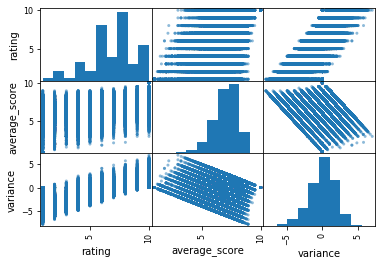

In [44]:
fig = pd.plotting.scatter_matrix(train[['rating','average_score','variance']])

## Graph 2 Average rating of each genre

In [21]:
score_dict = {}
for index, row in train.iterrows():
    genres = row[4].split('|')
    for gen in genres:
        if gen in score_dict:
            score_dict[gen].append(row[3])
        else:
            score_dict[gen] = [row[3]]

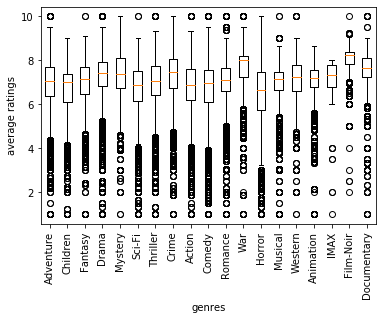

In [46]:
plt.boxplot(score_dict.values())
plt.xticks(list(range(1,20)),score_dict.keys(), rotation=90)
plt.xlabel('genres')
plt.ylabel('average ratings')
fig = plt.gcf()

##  Graph 3 Number of films in each genre

In [47]:
count = defaultdict(int)
for index, row in train.iterrows():
    genres = row[4].split('|')
    for gen in genres:
        count[gen] += 1

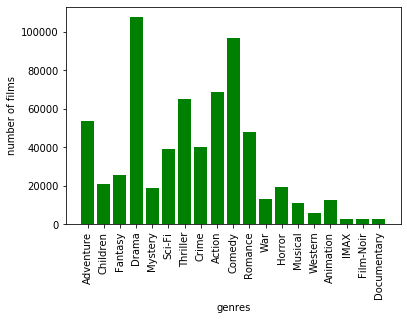

In [48]:
plt.bar(count.keys(), count.values(),color='g')
plt.xticks(rotation=90)
plt.xlabel('genres')
plt.ylabel('number of films')
fig = plt.gcf()

## Graph 4 Number of films each user rates

In [49]:
count_rating = defaultdict(int)
for index, row in train.iterrows():
    count_rating[row[0]] += 1

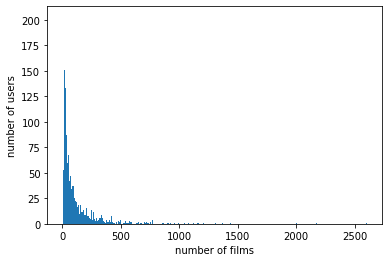

In [50]:
plt.hist(count_rating.values(),bins=500)
plt.xlabel('number of films')
plt.ylabel('number of users')
fig = plt.gcf()

## Graph 5 Variance of ratings of each genre of films

In [51]:
variance = defaultdict(float)
for index, row in train.iterrows():
    genres = row[4].split('|')
    for gen in genres:
        variance[gen] += row[5]

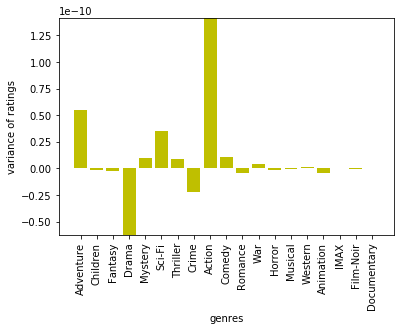

In [52]:
plt.bar(variance.keys(), variance.values(),color='y')
plt.xticks(rotation=90)
plt.xlabel('genres')
plt.ylabel('variance of ratings')
fig = plt.gcf()

# Data Analysis & Results

## Cosine Similarity

In [56]:
import math
from collections import Counter
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    if magA * magB == 0:
        return 0
    return dotprod / (magA * magB)

In [57]:
users = {}
for index,row in train.iterrows():
    if row[0] in users:
        users[row[0]].extend(row[4].split('|'))
    else:
        users[row[0]] = row[4].split('|')

In [58]:
for key in users:
    users[key] = list(set(users[key]))

In [112]:
answer = list(test.apply(lambda row: 1 if row.rating >= 6.0 else -1, axis=1))

In [113]:
pred = []
for index,row in test.iterrows():
    if row[0] not in users:
        pred.append(False)
    else:
        counterA = Counter(users[row[0]])
        counterB = Counter(row[4].split('|'))
        res = counter_cosine_similarity(counterA,counterB)
        if res > 0.3:
            pred.append(1)
        else:
            pred.append(-1)

In [117]:
sum(np.array(pred) == np.array(answer)) / len(answer)

0.7698619171502902

## Classic method

### We calculate each user's average rating for each genre of movie first and save into a dataframe

In [118]:
user_rating = defaultdict(list)
genre_rating = defaultdict(list)
last_user = 1
for index, row in train.iterrows():
    if row[0] != last_user:
        user_rating[last_user] = genre_rating
        genre_rating = defaultdict(list)
        last_user = row[0]
    genres = row[4].split('|')
    for gen in genres:
        genre_rating[gen].append(row[3])  

In [119]:
for user,rating in user_rating.items():
    for key,value in rating.items():
        rating[key] = [sum(value)/len(value)]

In [120]:
frames = []
for user,rating in user_rating.items():
    data = pd.DataFrame.from_dict(rating)
    frames.append(data)

In [121]:
df_user = pd.concat(frames,sort=False)

In [122]:
df_user.set_index(pd.Series(list(user_rating.keys())),inplace=True)
df_user.index.name = 'userId'

In [123]:
df_user.head()

,Adventure,Children,Fantasy,Drama,Mystery,Sci-Fi,Thriller,Crime,Action,Comedy,Romance,War,Horror,Musical,Western,Animation,IMAX,Film-Noir,Documentary
userId,,,,,,,,,,,,,,,,,,,
1,6.904455,6.599082,6.714009,7.756397,7.564128,7.117860,7.541193,7.891915,7.174452,7.107212,7.167975,7.627261,7.252730,7.413226,8.072794,6.883448,7.153846,NaN,NaN
2,7.583858,6.800000,7.405844,6.955556,6.645124,7.249075,6.721317,7.605442,7.511103,7.201896,7.140797,7.233164,5.746337,6.358333,7.438098,6.800000,6.800000,7.331361,NaN
3,6.950747,6.582382,7.217240,7.478415,7.198036,6.572171,7.057244,7.602656,6.775073,7.170722,7.461883,8.083648,6.567031,7.332899,7.488070,7.273578,NaN,7.082474,NaN
4,6.950745,7.039604,6.492986,6.828523,6.844158,6.571817,6.757774,6.464301,6.509078,6.391294,7.382287,8.158996,NaN,NaN,6.818533,NaN,NaN,NaN,NaN
5,7.081901,6.969567,6.786151,7.365239,6.899794,7.163044,7.216021,7.757410,7.086818,7.129127,6.915229,8.053777,8.268519,7.122426,7.083804,7.114327,7.546939,NaN,NaN


### We calculate the number of each genre of movies each user watches and save into another dataframe

In [124]:
user_count = defaultdict(list)
genre_count = defaultdict(int)
last_user = 1
for index, row in train.iterrows():
    if row[0] != last_user:
        user_count[last_user] = genre_count
        genre_count = defaultdict(int)
        last_user = row[0]
    genres = row[4].split('|')
    for gen in genres:
        genre_count[gen] += 1 

In [125]:
for user,count in user_count.items():
    for key,value in count.items():
        count[key] = [value]
        
frames = []
for user,count in user_count.items():
    data = pd.DataFrame.from_dict(count)
    frames.append(data)

df_count = pd.concat(frames,sort=False)
df_count.set_index(pd.Series(list(user_count.keys())),inplace=True)
df_count.index.name = 'userId'

In [126]:
df_count.head()

,Adventure,Children,Fantasy,Drama,Mystery,Sci-Fi,Thriller,Crime,Action,Comedy,Romance,War,Horror,Musical,Western,Animation,IMAX,Film-Noir,Documentary
userId,,,,,,,,,,,,,,,,,,,
1,71.0,18.0,67.0,40.0,18.0,38.0,41.0,20.0,63.0,39.0,11.0,8.0,42.0,3.0,4.0,9.0,1.0,NaN,NaN
2,14.0,1.0,1.0,19.0,4.0,19.0,18.0,1.0,18.0,9.0,6.0,4.0,16.0,2.0,2.0,1.0,1.0,1.0,NaN
3,49.0,10.0,20.0,56.0,11.0,92.0,50.0,21.0,61.0,49.0,15.0,5.0,32.0,5.0,3.0,4.0,NaN,1.0,NaN
4,5.0,1.0,1.0,7.0,3.0,4.0,12.0,6.0,11.0,10.0,4.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,17.0,11.0,11.0,26.0,2.0,8.0,15.0,7.0,14.0,24.0,15.0,1.0,1.0,8.0,2.0,6.0,3.0,NaN,NaN


### predict based on the average rating of each user on each genre

In [127]:
user_prefer_score = defaultdict(list)
for index,row in df_user.iterrows():
    for i in range(len(row)):
        if row[i] > 7:
            user_prefer_score[index].append(df_user.columns[i])

In [134]:
answer = list(test.apply(lambda row: 1 if row.rating >= 6.0 else -1, axis=1))

In [135]:
pred = []
for index,row in test.iterrows():
    if row[0] not in df_user.index:
        pred.append(-1)
    else:
        if set(user_prefer_score[row[0]]) & set(row[4].split('|')):
            pred.append(1)
        else:
            pred.append(-1)

In [136]:
sum(np.array(pred) == np.array(answer)) / len(answer)

0.7307384430658395

### predict based on the number of films each user watches on each genre

In [137]:
user_prefer_genre = defaultdict(list)
for index,row in df_count.iterrows():
    user_prefer_genre[index] = [df_count.columns[i] for i in sorted(range(len(row)), key=lambda i: row[i])[-5:]]

In [138]:
pred = []
for index,row in test.iterrows():
    if row[0] not in df_user.index:
        pred.append(-1)
    else:
        if set(user_prefer_genre[row[0]]) & set(row[4].split('|')):
            pred.append(1)
        else:
            pred.append(-1)

In [139]:
sum(np.array(pred) == np.array(answer)) / len(answer)

0.5986591955173104

# Ethics and Privacy
When it comes to privacy and ethical considerations, there are many factors that we have to consider in order for our project to meet these expectations. First, we insured that we are using information that is valid and not leaving out any information that would change the outcome. We want to make sure that we are not using any false information so that our project provides a more precise reflection. Secondly, we made sure that we have permission from the websites that we are taking information from. We want the readers of our project to see that we had help from rating websites and to give them the credit that they deserve. This project goes through the necessary procedures to be fair to rating websites as well as have their trust. Thirdly, we need to make sure that we are upholding the privacy of the user’s information from the website. In order to do this, we took out any personal information such as name, age, gender, etc. and labeled them using an id system. This insures that we are only using the necessary information for the experiment without breaking the privacy of the website and its users. Lastly, we want to make sure that we are not breaking any laws as well as not hurt the users or website in any way. Overall, the project will provide information that will be beneficial towards people that want to see ratings correlate with their favorite type of film. If we are able to get approval from others, others may try to build up from our project.

# Conclusion and Discussion